# Applies Deep Learning to ePodium dataset for prediction of Dyslexia.

#### Import Packages

In [1]:
import mne
import numpy as np
import os
import glob
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Precision, BinaryAccuracy, Recall
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

import local_paths
from functions import epodium, epodium_deep_learning, display_helper

from models import transformer
from models.dnn import fully_connected_model
from models.hfawaz import cnn, encoder

<br>

## Preparing data iterator (Sequence) as input to the deep learning models.
https://www.tensorflow.org/api_docs/python/tf/keras/utils/Sequence

#### Split processed epochs* into train and test sequence.

*In the context of electroencephalography (EEG), *epochs* are EEG segments in which an event occurs. During processing, the epochs are chosen to be 1 second in which the event occurs at 0.2s. In the context of deep learning, *epochs* are iterations over the entire training dataset.

First choose which processed data to use

In [2]:
processing_method = "autoreject"
if(processing_method == "autoreject"):
    path_processed = local_paths.ePod_processed_autoreject
if(processing_method == "ransac"):
    path_processed = local_paths.ePod_processed_ransac

train, test = epodium_deep_learning.split_train_test_datasets(path_processed)
train_sequence = epodium_deep_learning.EvokedDataIterator(train, path_processed, gaussian_noise = 1)
test_sequence = epodium_deep_learning.EvokedDataIterator(test, path_processed)

Analyzed: 228, bad: 42
186 files have enough epochs for analysis.
The dataset is split up into 138 train and 48 test experiments


<br>

## Deep Learning

The data is an *evoked* or *ERP* from a participant in the ePodium experiment. 60 EEG signals were averaged from -0.2 to +0.8 seconds after onset of an event. This is done for each of the 12 event types seperately.

__dimensions__: 
+ x (batches, timesteps, channels)
+ y (batches, labels)

__labels__: 
+ Binary: Sex, At risk of dyslexia, Group a/b
+ Regressive: Age, Vocabulary


#### Train model

In [6]:
model_name = "encoder_3"
model = encoder((32,512), 3)
epochs = 2
learning_rate = 2e-4

# Paths to save model info
base_path = os.path.join(local_paths.models, model_name)

path_history = os.path.join(base_path, "history.npy")
path_model = os.path.join(base_path, "model")
path_testset = os.path.join(base_path, "testset.txt")
path_weights = os.path.join(base_path, "weights.h5")

if os.path.exists(path_model):
    print(f"Model: '{model_name}' already exist. Delete the existing model first or rename this model.")    
else:
    print(f"Create model: {model_name}")
    if not os.path.exists(base_path):
        os.mkdir(base_path)

    # Save validation-set for future testing
    with open(path_testset, 'w') as f:
        for participant in test:
            f.write(participant + '\n')

    model.compile(optimizer=Adam(learning_rate=learning_rate), loss=BinaryCrossentropy(), metrics=[Precision(), BinaryAccuracy(), Recall()])
    checkpointer = ModelCheckpoint(filepath = path_weights, monitor='val_loss', verbose=1, save_weights_only=True, save_best_only=True)
    #reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.7, verbose=1) # add to callbacks if uncomment

    # Fit model
    history = model.fit(x=train_sequence, validation_data=test_sequence, epochs=epochs, callbacks=[checkpointer])

    np.save(path_history, history.history)
    model.save(path_model)

Create model: encoder_3
Epoch 1/2
18/18 [==============================] - ETA: 0s - loss: 0.5506 - precision_1: 0.4910 - binary_accuracy: 0.6528 - recall_1: 0.5578
Epoch 1: val_loss improved from inf to 0.57270, saving model to /volume-ceph/floris_storage/models/encoder_3/weights.h5
18/18 [==============================] - 70s 4s/step - loss: 0.5506 - precision_1: 0.4910 - binary_accuracy: 0.6528 - recall_1: 0.5578 - val_loss: 0.5727 - val_precision_1: 0.5000 - val_binary_accuracy: 0.6528 - val_recall_1: 0.4800
Epoch 2/2
18/18 [==============================] - ETA: 0s - loss: 0.4705 - precision_1: 0.5494 - binary_accuracy: 0.6927 - recall_1: 0.5391
Epoch 2: val_loss improved from 0.57270 to 0.48440, saving model to /volume-ceph/floris_storage/models/encoder_3/weights.h5
18/18 [==============================] - 60s 3s/step - loss: 0.4705 - precision_1: 0.5494 - binary_accuracy: 0.6927 - recall_1: 0.5391 - val_loss: 0.4844 - val_precision_1: 0.5000 - val_binary_accuracy: 0.6528 - val_r

INFO:tensorflow:Assets written to: /volume-ceph/floris_storage/models/encoder_3/model/assets


INFO:tensorflow:Assets written to: /volume-ceph/floris_storage/models/encoder_3/model/assets


#### Show Training History

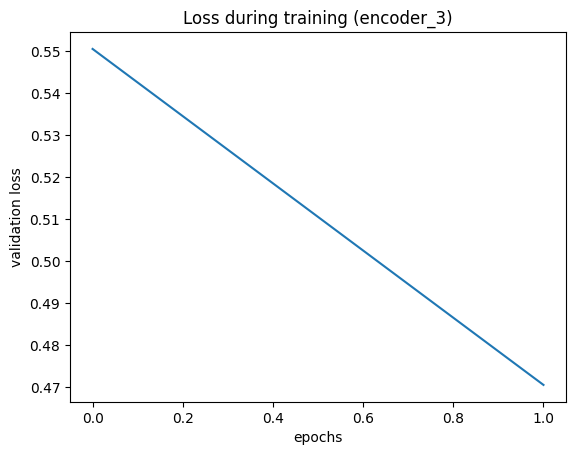

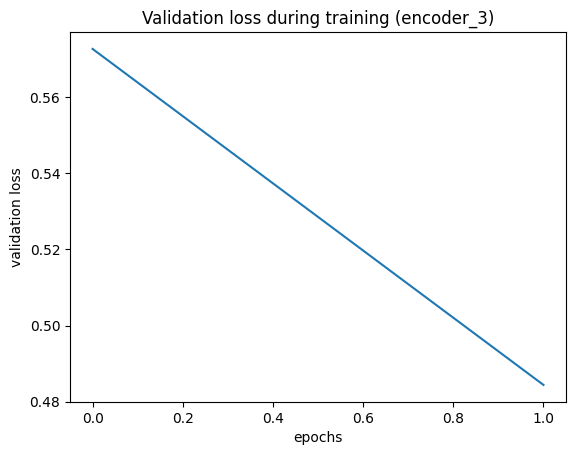

In [7]:
display_helper.show_plot(x = range(len(history.history['loss'])), y = history.history['loss'], xlabel = "epochs", ylabel = "validation loss", title = f"Loss during training ({model_name})")
display_helper.show_plot(x = range(len(history.history['loss'])), y = history.history['val_loss'], xlabel = "epochs", ylabel = "validation loss", title = f"Validation loss during training ({model_name})")